<a href="https://colab.research.google.com/github/eeolga/article/blob/main/3D_weighted_data_training_corelation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
import pandas as pd

In [3]:
CAD_path="/content/CAD_KLO_07082024.xlsx"

CAD_logs file data

In [4]:
data = pd.read_excel("/content/CAD_KLO_07082024.xlsx")

In [5]:
display(pd.DataFrame(data))

,user_id,tool_id,competency,tool_weight,activity_id,activity_weight,date,time,lesson
0,29455,3299,2,0.090909,20706,0.142857,2024-05-17,13:10:11,1
1,29455,233156,2,0.090909,20807,0.142857,2024-05-17,13:10:11,1
2,29455,3299,2,0.090909,20706,0.142857,2024-05-17,13:09:51,1
3,29455,233156,2,0.090909,20807,0.142857,2024-05-17,13:09:49,1
4,29455,3299,2,0.090909,20706,0.142857,2024-05-17,13:02:38,1
...,...,...,...,...,...,...,...,...,...
5650,29455,2949,1,0.090909,10103,0.071429,2024-02-09,19:54:20,0
5651,29455,2949,1,0.090909,10103,0.071429,2024-02-09,19:53:27,0
5652,29455,2949,1,0.090909,10102,0.071429,2024-02-09,19:53:27,0
5653,29455,2949,1,0.090909,10102,0.071429,2024-02-09,19:53:27,0


Index(['user_id', 'tool_id', 'competency', 'tool_weight', 'activity_id',
       'activity_weight', 'date', 'time', 'lesson'],
      dtype='object')
Non-numeric columns: Index(['date', 'time'], dtype='object')
Epoch [20/200], Loss: 0.3662, Val Loss: 0.3427
Epoch [40/200], Loss: 0.1012, Val Loss: 0.0991
Epoch [60/200], Loss: 0.0316, Val Loss: 0.0361
Epoch [80/200], Loss: 0.0138, Val Loss: 0.0195
Epoch [100/200], Loss: 0.0088, Val Loss: 0.0139
Epoch [120/200], Loss: 0.0068, Val Loss: 0.0115
Epoch [140/200], Loss: 0.0056, Val Loss: 0.0100
Epoch [160/200], Loss: 0.0049, Val Loss: 0.0088
Epoch [180/200], Loss: 0.0043, Val Loss: 0.0078
Epoch [200/200], Loss: 0.0038, Val Loss: 0.0069


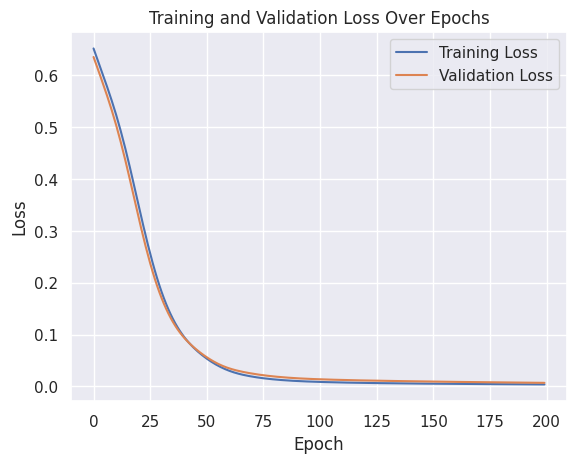

Raw outputs (first 10): tensor([2.0156e-01, 9.9925e-01, 3.4722e-04, 6.3109e-07, 9.9866e-01, 5.4892e-05,
        9.3723e-06, 9.9925e-01, 1.6064e-04, 1.1912e-04])
Unique values in predictions with threshold 0.5: tensor([0., 1.])
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       876
     class 1       1.00      1.00      1.00       255

    accuracy                           1.00      1131
   macro avg       1.00      1.00      1.00      1131
weighted avg       1.00      1.00      1.00      1131



In [44]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Load Data from Excel
file_path = '/content/CAD_KLO_07082024.xlsx'
data = pd.read_excel(file_path)

# Print the column names to verify 'competency' exists
print(data.columns)

# Assuming your Excel file has columns 'features' and 'target'
# Adjust 'competency' to the actual column name if necessary
X = data.drop('competency', axis=1)
y = data['competency'].values

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Handle non-numeric columns (example: drop them)
X = X.drop(non_numeric_cols, axis=1).values

# Ensure target values are 0 or 1
y = (y == 1).astype(float)

#  Preprocess Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Model
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

input_dim = X_train.shape[1]
model = ImprovedNN(input_dim)

# SDefine Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
num_epochs = 200
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        validation_losses.append(val_loss.item())

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    raw_outputs = model(X_test)
    print(f'Raw outputs (first 10): {raw_outputs[:10].flatten()}')

    # Adjust threshold if necessary
    threshold = 0.5
    y_predicted = (raw_outputs > threshold).float()
    unique_values = y_predicted.unique()
    print(f'Unique values in predictions with threshold {threshold}: {unique_values}')

    y_test_flat = y_test.flatten()
    if len(unique_values) == 1:
        print(f'Only one class ({unique_values.item()}) predicted with threshold {threshold}.')
    else:
        print(classification_report(y_test_flat, y_predicted, target_names=['class 0', 'class 1']))

Feature Engineering

In [11]:
df = pd.read_excel("/content/CAD_KLO_07082024.xlsx")
test_df = pd.read_excel("/content/CAD_KLO_07082024.xlsx")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5655 entries, 0 to 5654
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          5655 non-null   int64         
 1   tool_id          5655 non-null   int64         
 2   competency       5655 non-null   int64         
 3   tool_weight      5655 non-null   float64       
 4   activity_id      5655 non-null   int64         
 5   activity_weight  5655 non-null   float64       
 6   date             5655 non-null   datetime64[ns]
 7   time             5655 non-null   object        
 8   lesson           5655 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 397.7+ KB


In [12]:
def feature_engineering(df): #feature engineering function

    return df

In [13]:
df = feature_engineering(df)

In [14]:
df = df.drop(['date', 'time'], axis=1) # Remove columns I no longer need

In [15]:
df.isna().sum()  # Data Cleaning

,0
user_id,0
tool_id,0
competency,0
tool_weight,0
activity_id,0
activity_weight,0
lesson,0


In [17]:
def scale_min_max(df, col_name, xmin, xmax):  # Normalization
    df[col_name] = (df[col_name] - xmin) / (xmax - xmin)
    return df

train_activity_min = df['activity_weight'].min()
train_activity_max = df['activity_weight'].max()
df = scale_min_max(df, 'activity_weight', train_activity_min, train_activity_max)

df['activity_weight'].describe()

,activity_weight
count,5655.000000
mean,0.566446
std,0.388181
min,0.000000
25%,0.250000
50%,0.750000
75%,1.000000
max,1.000000


Data correlation

In [34]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:16], all_data.loc[16:].drop(['time'], axis=1)

df_train = pd.read_excel("/content/CAD_KLO_07082024.xlsx")
df_test = pd.read_excel("/content/CAD_KLO_07082024.xlsx")


df_train.name = 'Training Set'
df_test.name = 'Test Set'


dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['user_id'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 5655
Number of Test Examples = 5655

Training X Shape = (5655, 9)
Training y Shape = 5655

Test X Shape = (5655, 9)
Test y Shape = 5655

Index(['user_id', 'tool_id', 'competency', 'tool_weight', 'activity_id',
       'activity_weight', 'date', 'time', 'lesson'],
      dtype='object')
Index(['user_id', 'tool_id', 'competency', 'tool_weight', 'activity_id',
       'activity_weight', 'date', 'time', 'lesson'],
      dtype='object')


In [35]:
# Ensure 'timestamp' column is dropped from both training and test datasets
df_train_cleaned = df_train.drop(['time'], axis=1)
df_test_cleaned = df_test.drop([ 'time'], axis=1)

In [36]:
# Verify all columns in df_train_cleaned and df_test_cleaned are numeric
numeric_columns_train = df_train_cleaned.select_dtypes(include=[int, float]).columns
numeric_columns_test = df_test_cleaned.select_dtypes(include=[int, float]).columns

In [37]:
# Compute correlations only on numeric columns
df_train_corr = df_train_cleaned[numeric_columns_train].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)


In [38]:
df_test_corr = df_test_cleaned[numeric_columns_test].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [43]:
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1 # Training set correlations
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,activity_weight,competency,0.991786
8,activity_id,activity_weight,0.943698
10,activity_id,competency,0.941766
12,tool_id,activity_weight,0.655678
14,tool_id,competency,0.628801
16,tool_id,activity_id,0.554837


In [41]:
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,activity_weight,competency,0.991786
8,activity_id,activity_weight,0.943698
10,activity_id,competency,0.941766
12,tool_id,activity_weight,0.655678
14,tool_id,competency,0.628801
16,tool_id,activity_id,0.554837


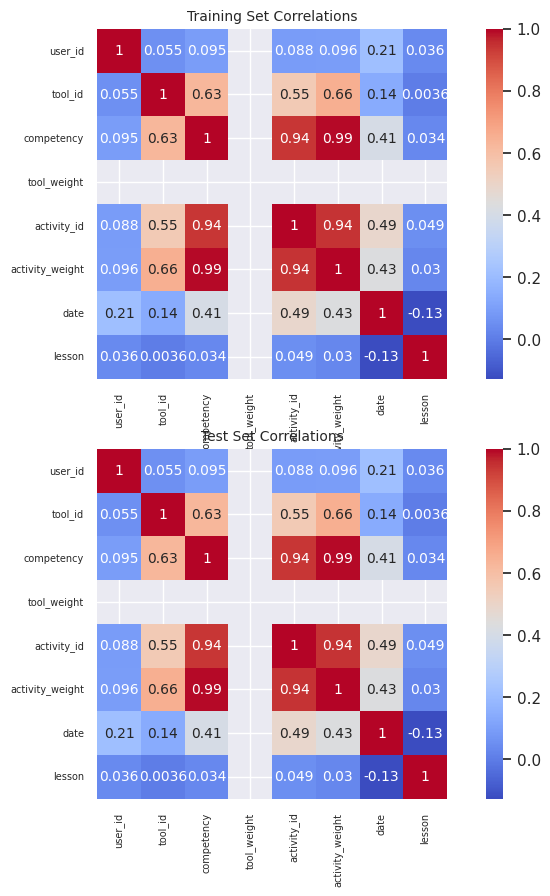

In [42]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))

sns.heatmap(df_train.drop(['time'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})
sns.heatmap(df_test.drop(['time'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})

for i in range(2):
    axs[i].tick_params(axis='x', labelsize=7)
    axs[i].tick_params(axis='y', labelsize=7)

axs[0].set_title('Training Set Correlations', size=10)
axs[1].set_title('Test Set Correlations', size=10)

plt.show()

Very high correlation is activity_id and competency 0.94,

competency and tool_id 0.63

and activity_id and tool_id 0.55.